# Step 1: Pre-process images over the glaciers

_Last modified 2022-07-01._

This script processes downloaded images prior to the Wavelet Transform Modulus Maxima (WTMM) segmentation analysis that produces the calving front delineations. The images will be:

     1) Grab image acquisition dates from the images
     2) Reproject all downloaded images
     3) Calculate terminus box dimensions and rasterize
     4) Rotate using weighted average glacier flow direction
     5) Crop rotated images to the same minimum dimensions and convert to pgm format

### The rotation step (4) requires an input ice velocity raster (vx and vy files).

For Greenland, we use the [MEASURES 2000-2015](https://nsidc.org/data/NSIDC-0670/versions/1) ice velocity mosaic.

### The image conversion step (5) requires the installation of ImageMagick.

Download [ImageMagick](https://imagemagick.org/script/download.php) command line software.

In [4]:
import numpy as np
import pandas as pd
import os
import subprocess
import shutil
import rasterio as rio
from shapely import geometry
import fiona
import fiona.crs
import datetime
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import rotate

from automated_terminus_functions import resize_pngs, distance

/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_85871/1057920446.py:13: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import rotate


In [6]:
#####################################################################################
# Enter folder containing the terminus box and RGI glacier outline shapefile(s):
# basepath = '/home/jukes/Documents/Sample_glaciers/' 
# downloadpath ='/media/jukes/jukes1/LS8aws/' # folder containing downloaded Landsat images
basepath = '/Users/jukesliu/Documents/LOWELL/shapefiles/' 
downloadpath ='/Users/jukesliu/Documents/LOWELL/LS8images/'  # folder containing downloaded Landsat images
csvpath = basepath # folder to store CSV files
# csvpath = '/home/jukes/Documents/Sample_glaciers/' # folder to store CSV files
# that describes the analysis (e.g., glacier or group of glaciers) 
folder_name = 'rotated_c2' # foldername to hold rotated collection 2 images
csvext = '_Lowell.csv' # same as in image download script, a file suffix

# Input your velocity input file info
vpath = basepath # path to folder containing velocity files
vx_name = 'greenland_vel_mosaic250_vx_v1.tif' # MEaSUREs product
vy_name = 'greenland_vel_mosaic250_vy_v1.tif' # MEaSUREs product
no_data_val = -2000000000.0 # no data value for the velocity maps
vt = 'day' # time unit for velocity (e.g., day for m/day, year for m/year)

# optional:
RGIpath = '/media/jukes/jukes1/RGI_shps/' # path to folder with all individual RGI glacier outline shapefiles

# Enter glacier IDs

BoxIDs = ['Lowell'] # Entering one or a few glaciers manually

# Run on a list of Box numbers (make sure BoxIDs list above is empty)
boxes = list(map(str, np.arange(12, 50, 1))) #1, 642, 1
for BoxID in boxes: # convert integers to 3-digit strings with leading zeros
    BoxID = BoxID.zfill(3) # pads zeros to the left 
    BoxIDs.append(BoxID)
    
# or read from a file
print(BoxIDs) # show the final BoxIDs
#####################################################################################

['Lowell', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049']


In [6]:
# filenames that will be written in this script
# all with common extension
print("CSV files that will be produced:"); print()
VEL_FILENAME = 'Glacier_vel'+csvext; print(VEL_FILENAME)
BOX_FILENAME = 'Buffdist'+csvext; print(BOX_FILENAME)
DATES_FILENAME = 'imgdates'+csvext; print(DATES_FILENAME) # acquisition dates for all downloaded Landsat images

CSV files that will be produced:

Glacier_vel_Lowell.csv
Buffdist_Lowell.csv
imgdates_Lowell.csv


In [15]:
# create new BoxID folders if they don't already exist
for BoxID in BoxIDs:
    # create folder to hold glacier shapefiles
    shapefilepath = basepath+'Box'+BoxID+'/' # path to that folder
    if os.path.exists(shapefilepath):
#         shutil.rmtree(shapefilepath) # remove the old folder
        print("Path exists already for Box", BoxID)
    else:
        os.mkdir(basepath+'Box'+BoxID)
            
    # create folder to hold glacier images (inside downloadpath)
    if os.path.exists(downloadpath+'Box'+BoxID):
        print("Path exists already in LS8aws for Box", BoxID)
    else:
        os.mkdir(downloadpath+'Box'+BoxID)
    
    # Now place terminus box shapefile and RGI glacier outline shapefile into the
    # boxespath folder. Done automatically below for the Greenland peripheral glaciers:
    if len(BoxID) == 3:
        ID = int(BoxID) # make into an integer in order to grab the .shp files

        # if the terminus box shapefile is not in this folder, then move it
        if not os.path.exists(shapefilepath+'Box'+BoxID+'.shp'):
            for filename in os.listdir(boxespath):
                if filename.startswith('BoxID_'+str(ID)):
                    shutil.copyfile(boxespath+filename, basepath+'Box'+BoxID+'/Box'+BoxID+filename[-4:])
                    print("Box"+BoxID+filename[-4:], "moved")
        else:
            print("Box"+BoxID+'.shp', "already in folder")

        if not os.path.exists(shapefilepath+'RGI_Box'+BoxID+'.shp'): # if the RGI shapfile is not in this folder
            # move RGI glacier outline into the new folder
            for filename in os.listdir(RGIpath):
                if filename.startswith('BoxID_'+str(ID)):
                    shutil.copyfile(RGIpath+filename, basepath+'Box'+BoxID+'/RGI_Box'+BoxID+filename[-4:])
                    print("RGI_Box"+BoxID+filename[-4:], "moved")
        else:
            print("RGI_Box"+BoxID+'.shp', "already in folder")

Path exists already for Box Helheim
Path exists already in LS8aws for Box Helheim


# 1) Grab image acquisition dates from downloaded images

In [16]:
# If the acquisition date datafile wasn't already created in the downloading step,
if not os.path.exists(csvpath+DATES_FILENAME): 
    # create it now
    datetimes = []; scenenames = []
    for BoxID in BoxIDs:
        for img in os.listdir(downloadpath+'Box'+BoxID+'/'):
            if img.startswith('L') and img.endswith('TIF'):
                datestr = img[17:25] # grab acquisition date from filename
                date = datetime.datetime.strptime(datestr, '%Y%m%d') # save as datetime object
                datetimes.append(date); scenenames.append(img[:40])
    dates_df = pd.DataFrame(list(zip(scenenames, datetimes)),columns=['Scene','datetime'])        
    # write to csv
    dates_df.to_csv(path_or_buf = basepath+DATES_FILENAME, sep=',')  
    
else: # if it exists already, don't overwrite
    print('Already created in the download step:')
    dates_df = pd.read_csv(csvpath+DATES_FILENAME)
dates_df.head()

Already created in the download step:


,Unnamed: 0,Scene,datetime
0,51,LE07_L1TP_233013_19990703_20200918_02_T1,1999-07-03
1,184,LE07_L1TP_232013_19990712_20200918_02_T1,1999-07-12
2,178,LE07_L1TP_231014_19990907_20200918_02_T1,1999-09-07
3,193,LE07_L1TP_233013_19991007_20200918_02_T1,1999-10-07
4,33,LE07_L1TP_232013_20000221_20200918_02_T1,2000-02-21


# 2) Reproject the images

When images are downloaded across many different Landsat path rows, it's possible that they will be in several UTM projections. As a result, you will need to reproject them into a single projection (e.g., Greenland Polar Stereographic). 

#### If all your images are in the same projection, then you can skip this step. Change SKIP to True.

In [7]:
######################################################################################
SKIP = False # if you want to skip this step, change to True
# desired_proj = '3413' # EPSG code for desired projection
desired_proj = '32608' # EPSG code for desired projection
suffix = '_RP' # suffix for reprojected images - something that indicates the projection
######################################################################################

for BoxID in BoxIDs:
    bp_out = downloadpath+'Box'+BoxID+'/' # path to downloaded files

    # create output reprojected folder if does not exist
    if os.path.exists(bp_out+'reprojected/'):
        print("Box"+BoxID, "Reprojected folder exists already.")
    else:
        os.mkdir(bp_out+'reprojected/')
        print("Box"+BoxID+" Reprojected directory made")
    
    for image in os.listdir(bp_out): # all downloaded images
        if image.startswith('L') and image.endswith('.TIF'):
            
            # if reprojection skipped, just move the image into the reprojected fodler
            if SKIP:
                shutil.copyfile(bp_out+image, bp_out+'reprojected/'+image)
            
            # if not skipped, reproject it
            else:
                imagename = image[:-4] # remove suffix
                rp_PS = "gdalwarp -t_srs EPSG:"+desired_proj+' '+bp_out+image+" "
                rp_PS += bp_out+'reprojected/'+imagename+suffix+".TIF"
                subprocess.run(rp_PS, shell=True,check=True)   

BoxLowell Reprojected directory made


# 3) Calculate terminus box dimensions and rasterize 
In this section, the minimum dimension of the terminus box is calculated which will be used in the generation of glacier flowlines in the analyze_wtmm_results.ipynb script.

In [16]:
# Calculate the minimum dimensions of the terminus boxes
mindimensions = [] # initialize empty list
for BoxID in BoxIDs:
    for file in os.listdir(basepath+'Box'+BoxID+'/'):
        if 'UTM' in file and '.shp' in file and "Box" in file: # identify UTM projected box
            boxpath = basepath+"Box"+BoxID+"/"+file  
            termbox = fiona.open(boxpath)
    
    # automatically calculate spatial resolution of images and grab the extent
    for img in os.listdir(downloadpath+'Box'+BoxID+'/'):
        if img.startswith('L') and img.endswith('TIF'):
            img_reader = rio.open(downloadpath+'Box'+BoxID+'/'+img)
            PIXRES = img_reader.transform[0]
            print('Image spatial resolution of',PIXRES,' meters calculated from ',img)
            break # stop after the first image
            
    # grab the box coordinates:
    box = termbox.next(); box_geom= box.get('geometry'); box_coords = box_geom.get('coordinates')[0]
    points = []
    for coord_pair in box_coords:
        lat = coord_pair[0]; lon = coord_pair[1]; points.append([lat, lon])
            
    # Calculate distance between coord 1 and 2 and between 2 and 3
    coord1 = points[0]; coord2 = points[1]; coord3 = points[2]   
    dist1 = distance(coord1[0], coord1[1], coord2[0], coord2[1]);
    dist2 = distance(coord2[0], coord2[1], coord3[0], coord3[1]) 
    mindim = int(np.min([dist1, dist2]))/PIXRES # calculate minimum dimensions, converted into pixels
    mindimensions.append(int(mindim))

if os.path.exists(csvpath+BOX_FILENAME): # if the buffer distance was calculated in the previous step
    buff_df = pd.read_csv(csvpath+BOX_FILENAME, dtype=str)
    buff_df['min_dim_px'] = mindimensions # add the minimum dimensions to the existing data
else: # if not, create a new data file
    buff_df = pd.DataFrame(list(zip(BoxIDs, mindimensions)), columns=['BoxID','min_dim_px'])
buff_df    

Image spatial resolution of 15.0  meters calculated from  LC08_L1TP_233013_20131005_20200912_02_T1_B8_BufferHelheim.TIF


/home/jukes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.


,Unnamed: 0,BoxID,Buff_dist_m,min_dim_px
0,0,Helheim,8193,357


In [17]:
# write to csv
buff_df.to_csv(basepath+BOX_FILENAME) 

Then, the terminus boxes are rasterized using the **gdal_rasterize** command with the following syntax:

    gdal_rasterize -burn 1.0 -tr x_resolution y_resolution -a_nodata 0.0 path_to_terminusbox.shp path_to_terminusbox_raster.TIF

and subset to the image dimensions using **gdal_warp**:

    gdalwarp -cutline path_to_Buffer###.shp -crop_to_cutline path_to_terminusbox_raster.TIF path_to_subset_raster_cut.TIF

These rasterized terminus boxes will be used as a mask during the 2D WTMM analysis.     

In [18]:
# Rasterize images
for index, row in buff_df.iterrows():
    BoxID = row['BoxID']
    terminusbox_path = basepath+"Box"+BoxID+"/Box"+BoxID # path to box
    buffer_path = basepath+"Box"+BoxID+"/Buffer"+BoxID # path to buffer
    
    terminusraster_path = basepath+"Box"+BoxID+"/Box"+BoxID+".TIF" # path to rasterized box
    cutraster_path = basepath+"Box"+BoxID+"/Box"+BoxID+"_raster_cut.TIF" # name for cropped file
    
    # Set rasterization command:
    rasterize_cmd = 'gdal_rasterize -burn 1.0 -tr '+str(PIXRES)+' '+str(PIXRES) # PIXRES from image
    rasterize_cmd += ' -a_nodata 0.0 -ot Int16 '+terminusbox_path+'.shp '+terminusraster_path
    print("Rasterize:", rasterize_cmd); print()
    
    # Set subsetting command:
    if not os.path.exists(buffer_path+'.shp'): # if there is a buffer shapefile
        subsetpath = buffer_path # use it to subset the rasterized terminus box
    else: # otherwise, use bounds from downloaded image
        with fiona.open(terminusbox_path+'.shp', "r") as source: # grab EPSG of terminus box
            source_crs = source.crs['init'].split(':')[1]
        rp_path = downloadpath+'Box'+BoxID+'/reprojected/' # path to the reprojected images
        ref_img = rio.open(rp_path+os.listdir(rp_path)[0]) # grab the first image
        img_bounds = geometry.Polygon([geometry.Point(ref_img.bounds.left, ref_img.bounds.top),
                    geometry.Point(ref_img.bounds.right, ref_img.bounds.top),
                    geometry.Point(ref_img.bounds.right, ref_img.bounds.bottom),
                    geometry.Point(ref_img.bounds.left, ref_img.bounds.bottom),
                    geometry.Point(ref_img.bounds.left, ref_img.bounds.top)])
        # Define a polygon feature geometry with one attribute
        schema = {'geometry': 'Polygon','properties': {'id': 'int'}}
        # Write a new Shapefile
        with fiona.open(basepath+"Box"+BoxID+'/img_bounds_Box'+BoxID+'.shp', 'w', 'ESRI Shapefile', schema,
                        crs=fiona.crs.from_epsg(source_crs))as c:
            ## If there are multiple geometries, put the "for" loop here
            c.write({'geometry': geometry.mapping(img_bounds),'properties': {'id': 123},})
        subsetpath = basepath+"Box"+BoxID+'/img_bounds_Box'+BoxID # use this path
        
    subset_cmd = 'gdalwarp -overwrite -ot Int16 -cutline '+subsetpath+'.shp -crop_to_cutline '
    subset_cmd += terminusraster_path+' '+cutraster_path
    print('Subset:', subset_cmd)
    
    subprocess.run(rasterize_cmd, shell=True,check=True) # rasterize with command terminal
    subprocess.run(subset_cmd, shell=True,check=True) # subset to buffer with command terminal
    

Rasterize: gdal_rasterize -burn 1.0 -tr 15.0 15.0 -a_nodata 0.0 -ot Int16 /home/jukes/Documents/Sample_glaciers/BoxHelheim/BoxHelheim.shp /home/jukes/Documents/Sample_glaciers/BoxHelheim/BoxHelheim.TIF

Subset: gdalwarp -overwrite -ot Int16 -cutline /home/jukes/Documents/Sample_glaciers/BoxHelheim/img_bounds_BoxHelheim.shp -crop_to_cutline /home/jukes/Documents/Sample_glaciers/BoxHelheim/BoxHelheim.TIF /home/jukes/Documents/Sample_glaciers/BoxHelheim/BoxHelheim_raster_cut.TIF


# 4) Rotate all images so glacier flow is to the right

## 4A) Calculate weighted average flow direction 

The following code processes ice velocity (vx, vy) rasters to determine each glacier of interest's weighted average flow direction. These files should be placed in the base directory (basepath). The rasters are subset using the terminus box shapefile or the Randolph Glacier Inventory outlines using a GDAL command (**gdalwarp**) with the following syntax:

    gdalwarp -cutline path_to_terminusbox.shp -crop_to_cutline path_to_input_velocity.TIF path_to_output_velocity.TIF

In [19]:
# crop the velocity raster to the RGI shapefile if available, terminus box if not
for BoxID in BoxIDs:
    print('Box'+BoxID)
    terminus_path = basepath+"Box"+BoxID+"/RGI_Box"+BoxID+".shp"  # path to RGI shapefile

    if not os.path.exists(terminus_path): # if the RGI shapefile does not exist
        terminus_path = basepath+"Box"+BoxID+"/Box"+BoxID+".shp"  # set the path to the box shapefile instead 
        print('Using terminus box.')
    else:
        print('Using RGI glacier outline.')

    vx_in = basepath+vx_name; vy_in = basepath+vy_name # input velocity file paths
    
    # output paths for the cropped velocity data:
    vx_out = terminus_path[:-4]+'_'+vx_name; vy_out = terminus_path[:-4]+'_'+vy_name
    
    # subset x and y velocity files
    v_subset1 = 'gdalwarp -overwrite -cutline '+terminus_path+' -crop_to_cutline '+vx_in+" "+vx_out
    v_subset2 = 'gdalwarp -overwrite -cutline '+terminus_path+' -crop_to_cutline '+vy_in+" "+vy_out
    subprocess.run(v_subset1, shell=True, check=True)
    subprocess.run(v_subset2, shell=True, check=True)
    
    print("Box"+BoxID+' done.')

BoxHelheim
Using terminus box.
BoxHelheim done.


Next, these subset velocity rasters are opened using the **rasterio** package and read into arrays. They are filtered for anomalous values and the velocity magnitudes are converted into weights. Then the **numpy.average()** function is used to calculated the weighted average flow directions where the flow directions of the pixels where the highest velocities are found are weighted higher. The resulting average flow direction will be used to rotate the images of the glaciers so that their flow is due right.

#### For the slow-moving Greenland peripheral glaciers, the ice velocities are very uncertain. Below, we use the manual delineations of the Greenland peripheral glaciers in 2000 and 2015 to approximate the flow direction.

In [19]:
##################################################################################################
# ONLY APPLIES TO GREENLAND PERIPHERAL GLACIERS
gperiph = True # SWITCH TO FALSE IF NOT USING THE PERIPHERAL GLACIER DATA

badvelocities = ['301', '289', '283', '265', '241', '223', '285', '181', '097', '091', '067','083',
                 '221', '173', '113', '101', '089', '082', '100', '112', '118', '130', '160', '196', 
                 '208', '226', '256', '262', '280', '298', '322', '072', '074', '080', '082', '084',
                '102', '114', '134', '132', '144', '159', '188', '189', '198', '207', '212', '222',
                '224', '234', '242', '243', '249', '254', '258', '264', '267', '272', '273', '278', 
                '282', '284', '288', '297', '305', '306', '307', '315', '318', '321', '324', '327',
                '330', '331', '338', '341', '344', '354', '356', '357', '358', '359', '362', '363',
                 '364', '369', '370', '371', '372', '373', '374', '376', '377', '379', '380', '381', 
                 '382', '383', '384', '385', '386', '387', '388', '389', '390', '391', '392', '393',
                 '394', '395', '396', '397', '398', '399', '400', '401' ,'404', '405', '406', '407',
                 '408', '409', '410', '414', '415', '416', '417', '418', '419', '420', '421', '422',
                 '427', '430', '431', '434', '436', '438', '440']
print(badvelocities)

# path to the folder with the 2000-2015 manual terminus delineations:
path2000_2015 = '/media/jukes/easystore/TEMP_STORE_FROM_JUKES1/2000_2015/'
###################################################################################################

['301', '289', '283', '265', '241', '223', '285', '181', '097', '091', '067', '083', '221', '173', '113', '101', '089', '082', '100', '112', '118', '130', '160', '196', '208', '226', '256', '262', '280', '298', '322', '072', '074', '080', '082', '084', '102', '114', '134', '132', '144', '159', '188', '189', '198', '207', '212', '222', '224', '234', '242', '243', '249', '254', '258', '264', '267', '272', '273', '278', '282', '284', '288', '297', '305', '306', '307', '315', '318', '321', '324', '327', '330', '331', '338', '341', '344', '354', '356', '357', '358', '359', '362', '363', '364', '369', '370', '371', '372', '373', '374', '376', '377', '379', '380', '381', '382', '383', '384', '385', '386', '387', '388', '389', '390', '391', '392', '393', '394', '395', '396', '397', '398', '399', '400', '401', '404', '405', '406', '407', '408', '409', '410', '414', '415', '416', '417', '418', '419', '420', '421', '422', '427', '430', '431', '434', '436', '438', '440']


In [20]:
# calculate glacier flow direction and speed
boxes = []; avg_rot = []; max_mag = []; num_cells = [] # to hold the boxIDs, rotation angle, max. glacier speed, and number of pixels

for BoxID in BoxIDs:
    rot_angles = []; max_magnitudes = [] # store angles and speeds from all pixels
    
    # determine if RGI outline was used to subset velocities
    rgi_exists = 0
    for file in os.listdir(basepath+"Box"+BoxID):
        if file.startswith('RGI'):
            rgi_exists = 1
            
    if rgi_exists == 1: # if yes, open those files    
        vx = rio.open(basepath+"Box"+BoxID+"/RGI_Box"+BoxID+'_'+vx_name, "r") 
        vy = rio.open(basepath+"Box"+BoxID+"/RGI_Box"+BoxID+'_'+vy_name, "r") 
    else: # if not, they were subset using the boxes. Open those files
        vx = rio.open(basepath+"Box"+BoxID+"/Box"+BoxID+'_'+vx_name, "r") 
        vy = rio.open(basepath+"Box"+BoxID+"/Box"+BoxID+'_'+vy_name, "r") 
    vx_array = vx.read(); vy_array = vy.read() # read as numpy array
    
    # remove no data values
    vx_masked = vx_array[vx_array != no_data_val]
    vy_masked = vy_array[vy_array != no_data_val]
    
    # calculate flow direction
    direction = np.arctan2(vy_masked, vx_masked)*180/np.pi 
    # transform so any negative angles are placed on 0 to 360 scale:
    if len(direction[direction < 0]) > 0:
        direction[direction < 0] = 360.0+direction[direction < 0]
    
    # calculate speed (flow magnitude)
    magnitude = np.sqrt((vx_masked*vx_masked) + (vy_masked*vy_masked)) 
    
    ncells = len(direction) # number of pixels
    if ncells > 0:
        # Determine if there are a large number of direction pixels with values > 200.0
        # If so, it's probably pointing East
        dir_range = direction.max() - direction.min()
        if dir_range > 200.0 and len(direction[direction > 200]): # if large range and values above 200
            direction[direction > 180] = direction[direction > 180] - 360.0 # transform those values on a negative scale
            # calculate weights (0 - 1) from magnitudes
            mag_range = magnitude.max() - magnitude.min()
            stretch = 1/mag_range; weights = stretch*(magnitude - magnitude.min()) # weights for averaging
            avg_dir = np.average(direction, weights=weights) # calculate average flow direction
            if avg_dir < 0: # if negative:
                avg_dir = avg_dir + 360.0 # transform back to 0 to 360 scale
        else:
            mag_range = magnitude.max() - magnitude.min(); stretch = 1/mag_range
            weights = stretch*(magnitude - magnitude.min())
            avg_dir = np.average(direction, weights=weights)
                
        if vt == 'day':
            max_magnitude = magnitude.max()
        elif vt == 'year':
            yr_day_conv = 0.00273973 # conversion to m/d from m/a
            max_magnitude = magnitude.max()*yr_day_conv  
    else: # no velocity pixels remaining once cropped
        avg_dir = np.NaN ; max_magnitude = np.NaN # no velocities to calculate this with
    
    if gperiph == True and BoxID in badvelocities: # ONLY APPLIES TO GREENLAND PERIPHERAL GLACIERS
        # grab the 2000 and 2015 delineation centroids:
        shp2000 = fiona.open(path2000_2015+'GreenlandPeriph_term2000_'+BoxID+'.shp'); feat2000= shp2000.next()
        lineshp2000 = LineString(feat2000['geometry']['coordinates'])
        cent2000 = np.array(lineshp2000.centroid)

        shp2015 = fiona.open(path2000_2015+'GreenlandPeriph_term2015_'+BoxID+'.shp'); feat2015= shp2015.next()
        lineshp2015 = LineString(feat2015['geometry']['coordinates'])
        cent2015 = np.array(lineshp2015.centroid)

        # grab displacements and use to calculate flow direction in degrees
        y = cent2000[1] - cent2015[1]; x = cent2000[0] - cent2015[0]
        avg_dir = np.arctan2(y,x)*180/np.pi
        if avg_dir < 0:
            avg_dir = 360.0+avg_dir
         
        # if max_magnitude cannot be calculated from the velocity raster (pixels == 0)
        if ncells == 0:
            # use displacements and time to approximate speed in m/d
            yrs = 15.0 # 2000 to 2015
            max_magnitude = np.sqrt((y*y)+(x*x))/yrs*yr_day_conv
        ncells = np.NaN # enter NaN to indicate that velocity raster was not used
   
    # Append values to lists:
    avg_rot.append(avg_dir); max_mag.append(max_magnitude); boxes.append(BoxID); num_cells.append(ncells)  

# store the flow direction (rotation angle), maximum magnitude
velocities_df = pd.DataFrame(list(zip(boxes,avg_rot, max_mag, num_cells)), 
                             columns=['BoxID','Flow_dir', 'Max_speed', 'Pixels'])
velocities_df = velocities_df.sort_values(by='BoxID')
velocities_df # display

,BoxID,Flow_dir,Max_speed,Pixels
0,Helheim,356.771102,7970.208496,412


In [21]:
# write velocity data to CSV
velocities_df.to_csv(path_or_buf = basepath+VEL_FILENAME, sep=',')

## 4B) Rotate images by glacier flow direction

In [4]:
# Read in the glacier velocity file as velocities_df if not already loaded:
velocities_df = pd.read_csv(basepath+VEL_FILENAME, sep=',', dtype=str, usecols=[1,2,3,4])
velocities_df = velocities_df.set_index('BoxID')
velocities_df.head()

,Flow_dir,Max_speed,Pixels
BoxID,,,
Helheim,356.7711019515991,7970.20849609375,412


In [5]:
# make directory for rotated images in BoxID folders if it doesn't already exist
for index, row in velocities_df.iterrows():
    BoxID = index
    if os.path.exists(downloadpath+"Box"+BoxID+'/'+folder_name+'/'):
        print("Rotated image folder already exists.")
    else:
        os.mkdir(downloadpath+"Box"+BoxID+'/'+folder_name+'/')
        print("Rotated image folder made for Box"+BoxID)

Rotated image folder already exists.


In [24]:
# move rasterized terminus box into reprojected folder, since it will also need to be rotated:
for index, row in velocities_df.iterrows():
    BoxID = index
    boxfile = 'Box'+BoxID+'_raster_cut.TIF'
    boxrasterpath = basepath+'Box'+BoxID+'/'+boxfile
    newpath = downloadpath+'Box'+BoxID+'/reprojected/'+boxfile
    shutil.copyfile(boxrasterpath, newpath)

In [25]:
# convert all images to png for rotation using image magick
for index, row in velocities_df.iterrows():
    BoxID = index
#     command = 'cd '+downloadpath+'Box'+BoxID+'/reprojected/; magick mogrify -format png *.TIF' # on Mac
    command = 'cd '+downloadpath+'Box'+BoxID+'/reprojected/; mogrify -format png *.TIF' # on Linux
    subprocess.run(command, shell=True,check=True)
print('Conversion to PNG finished.')

CalledProcessError: Command 'cd /media/jukes/jukes1/LS8aws/BoxHelheim/reprojected/; mogrify -format png *.TIF' returned non-zero exit status 1.

**_CalledProcessError: Command returned non-zero exit status 1._ may occur even if the conversion was successful. Check that the pngs have been created and proceed.**

BoxHelheim
LC08_L1TP_232013_20200510_20200820_02_T1_B8_BufferHelheim_PS.png
rotated image shape: (1709, 1838)
rotated iarray shape: (1709, 1838, 2)


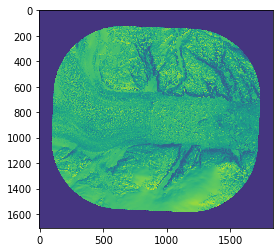

In [24]:
# rotate the images
for index, row in velocities_df.iterrows():
    BoxID = index; print("Box"+BoxID) # keep track of progress
    for file in os.listdir(downloadpath+"Box"+BoxID+'/reprojected/'):
        if file.endswith('.png'):
            print(file)
            # grab the transform from the geotiff version
            gtiff = rio.open(downloadpath+"Box"+BoxID+'/reprojected/'+file[:-4]+'.TIF')
            [left,bottom,right,top] = gtiff.bounds # grab extent
            pixres = gtiff.transform[0] # grab pixel resolution [m]
            
            # open and rotate
            img  = Image.open(downloadpath+"Box"+BoxID+'/reprojected/'+file)
#             rotated = img.rotate(-float(row['Flow_dir']))
            rotated = rotate(img,angle=-float(row['Flow_dir']),reshape=False)
            rot_img = Image.fromarray(rotated)
            print('rotated image shape:', rotated.shape)
            
            # rotate img coordinates too (grid center coords)
            xi, yi = np.meshgrid(np.arange(left+pixres/2,right,pixres),
                                 np.flip(np.arange(bottom+pixres/2,top,pixres)), # flip the y
                                 indexing='xy')
            iarray = np.dstack((xi,yi))
            if iarray.shape[:2] != rotated.shape: # if x y dimensions don't match,
                # try again
                xi, yi = np.meshgrid(np.arange(left+pixres/2,right-pixres/2,pixres),
                             np.flip(np.arange(bottom+pixres/2,top-pixres/2,pixres)), # flip the y
                             indexing='xy'); iarray = np.dstack((xi,yi))
            rot_iarray = rotate(iarray,angle=-float(row['Flow_dir']),reshape=False)
            print("rotated iarray shape:", rot_iarray.shape)
            
            # visualize rotated image
            plt.imshow(rotated)
            plt.show()
            
            # save
            rot_img.save(downloadpath+"Box"+BoxID+'/'+folder_name+'/R_'+file)
#             break # remove this to run on multiple

# 5) Crop all images to the same size and convert to pgm

In [25]:
# crop all images to the same size
for BoxID in BoxIDs:
    resizepath = downloadpath+"Box"+BoxID+'/'+folder_name+'/' # path to rotated images
    orig_img_idxs = resize_pngs(resizepath,rot_iarray) # crop all and indices as well
    
# save original image indexes (geographic coordinates)
np.savetxt(resizepath+'img_xidx_Box'+BoxID+'.csv',orig_img_idxs[:,:,0]) # x
np.savetxt(resizepath+'img_yidx_Box'+BoxID+'.csv',orig_img_idxs[:,:,1]) # y

# make sure these dimensions match:

1709 1838 (1709, 1838, 2)


In [7]:
# convert all final files to pgm
for index, row in velocities_df.iterrows():
    BoxID = index
#     command = 'cd '+downloadpath+'Box'+BoxID+'/'+folder_name+'/; magick mogrify -depth 16 -format pgm *.png' # Mac
    command = 'cd '+downloadpath+'Box'+BoxID+'/'+folder_name+'/; mogrify -depth 16 -format pgm *.png' # Linux
    subprocess.call(command, shell=True)

In [26]:
# remove intermediate pngs
for BoxID in BoxIDs:
    resizepath = downloadpath+"Box"+BoxID+'/'+folder_name+'/' # path to rotated & cropped images
    rp_path = downloadpath+"Box"+BoxID+'/reprojected/' # path to reprojected images
    for path in [resizepath, rp_path]: # remove pngs from both
        for png in os.listdir(path):
            if png.endswith('.png') and 'raster_cut' not in png: # remove all besides the rasterized box
                os.remove(path+png)

In [ ]:
# # rename the rasterized terminus box files if necessary
# for BoxID in BoxIDs:
#     files = os.listdir(downloadpath+'Box'+BoxID+'/rotated_c2/')
#     for file in files:
#         if file.startswith('R_Box'+BoxID+'_cut'):
#             rpath = downloadpath+'Box'+BoxID+'/rotated_c2/'
#             os.rename(rpath+file, rpath+'R_Box'+BoxID+'_raster_cut'+file[-4:])